#### Loading the necessary libraries and packages

In [1]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.utils import Sequence
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Define paths

In [2]:
train_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '400', 'train')
val_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '400', 'val')
train_labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'small', '400', 'train')
val_labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'small', '400', 'val')
load_models_path = os.path.join('/home', 'renat_sergazinov', 'python-git-workspace', 
                               'PhotoForceReconML', 'models')
save_models_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'models', 'small', '400')

#### Data preprocessing and augmentation

Load the data from the directory. The data are the images of particles split into subdirectories based on the number of forces acting on the particle. The labels should be loaded from a separate directory. Each label corresponds to two particles. 

The size of all images is adjusted so that all images are 128*128 using nearest neighbor interpolation. Validation split is performed: 20% is set aside for validation. Additionally images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1].

In [2]:
# Define gaussian blur class
class GaussBlur:
    def __init__(self, radius):
        self.radius = radius
    def blur(self, image):
        return gaussian_filter(image, sigma = self.radius)

In [3]:
# Define class for data generation
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_image_paths = None, labels = None,  
                 batch_size = 32, dim = None, n_channels = 3, rescale = 1, 
                 shuffle=True, save_dir = None, preprocessing_func = None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_image_paths = list_image_paths
        self.n_channels = n_channels
        self.rescale = rescale
        self.shuffle = shuffle
        self.save_dir = save_dir
        self.preprocessing_func = preprocessing_func
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indices)
        
        if self.save_dir is not None:
            for i in range(X.shape[0]):
                path = os.path.join(self.save_dir, 'img' + str(i) + '.jpg')
                plt.imsave(path, np.asarray(X[i, ]), vmin = 0, vmax = 1)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(len(self.list_image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, indices):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Initialisation
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        list_image_paths_batch = [self.list_image_paths[k] for k in indices]
        
        # Get labels
        y = np.array([self.labels[k, :] for k in indices])
        
        # Generate data
        for i, image_path in enumerate(list_image_paths_batch):
            # Load image and transform
            image = Image.open(os.path.join(image_path))
            if self.dim is not None:
                image = image.resize(self.dim, resample = Image.NEAREST)
            image = np.array(image)[:, :, :self.n_channels]
            image = image * self.rescale
            if self.preprocessing_func is not None:
                image = self.preprocessing_func(image)
            # Store sample
            X[i,] = image

        return X, y

In [4]:
# Define sorter of image names in order by image number (default is alphanumric)
def sorter(item):
    # Since highest marks first, least error = most marks
    radius = float(item[1 : item.find('_')])
    num_img = int(item[item.find('g') + 1 : item.find('j') - 1])
    return (radius, num_img)

#### Loading the data

In [5]:
# Load the train and validation sets

X_train, X_val = {}, {}
y_train, y_val = {}, {}

for k in range(5):
    i = k + 2
    X_path_train = os.path.join(train_image_path, str(i))
    X_path_val = os.path.join(val_image_path, str(i))
    X_train[i] = [os.path.join(X_path_train, name) for name in sorted(os.listdir(X_path_train), key = sorter)]
    X_val[i] = [os.path.join(X_path_val, name) for name in sorted(os.listdir(X_path_val), key = sorter)]
    y_train[i] = np.load(os.path.join(train_labels_path, str(i), 'mags.npy'))
    y_val[i] = np.load(os.path.join(val_labels_path, str(i), 'mags.npy'))

In [6]:
# Apply data generators
gaussblur = GaussBlur(1)
params = {'batch_size': 32, 
          'dim': (128, 128), 
          'n_channels': 3, 
          'rescale': 1 / 255, 
          'shuffle': True, 
          'save_dir': None,
          'preprocessing_func': gaussblur.blur
          }

training_generator = {}
validation_generator = {}

for k in range(5):
    i = k + 2
    training_generator[i] = DataGenerator(X_train[i], y_train[i], **params)
    validation_generator[i] = DataGenerator(X_val[i], y_val[i], **params) 

#### InceptionResNetV2 Models Building

Convolutional neural networks is defined and compiled in this step.

In [7]:
# Load models
models_m = dict()                         
for k in range(5):
     i = k + 2
     models_m[i] = load_model(os.path.join(load_models_path, 'InceptionResNetV2_mags_'+str(i)+'.h5'))

In [8]:
for k in range(5):
    i = k + 2
    models_m[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 55,912,674
Trainable params: 55,852,130
Non-trainable params: 60,544
____________________________________________

In [9]:
for k in range(5):
    i = 2 + k
    models_m[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = dict()
for k in range(5):
    i = k + 2
    model_path = os.path.join(save_models_path, 'InceptionResNetV2_mags_'+str(i)+'.h5')
    mc[i] = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [11]:
epochs = 1000
history = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history[i] = models_m[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 0.2287 - mean_absolute_error: 0.2287
Epoch 00001: val_loss improved from inf to 0.20252, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/InceptionResNetV2_mags_2.h5
10/10 [==============================] - 5s 475ms/step - loss: 0.2287 - mean_absolute_error: 0.2287 - val_loss: 0.2025 - val_mean_absolute_error: 0.2025
Epoch 2/1000
10/10 [==============================] - ETA: 0s - loss: 0.1756 - mean_absolute_error: 0.1756
Epoch 00002: val_loss improved from 0.20252 to 0.15576, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/InceptionResNetV2_mags_2.h5
10/10 [==============================] - 3s 299ms/step - loss: 0.1756 - mean_absolute_error: 0.1756 - val_loss: 0.1558 - val_mean_absolute_error: 0.1558
Epoch 3/1000
10/10 [==============================] - ETA: 0s - loss: 0.1327 - mean_absolute_error: 0.132

Epoch 47/1000
10/10 [==============================] - ETA: 0s - loss: 0.0199 - mean_absolute_error: 0.0199
Epoch 00047: val_loss did not improve from 0.01288
10/10 [==============================] - 1s 147ms/step - loss: 0.0199 - mean_absolute_error: 0.0199 - val_loss: 0.0155 - val_mean_absolute_error: 0.0155
Epoch 48/1000
10/10 [==============================] - ETA: 0s - loss: 0.0184 - mean_absolute_error: 0.0184
Epoch 00048: val_loss did not improve from 0.01288
10/10 [==============================] - 1s 143ms/step - loss: 0.0184 - mean_absolute_error: 0.0184 - val_loss: 0.0160 - val_mean_absolute_error: 0.0160
Epoch 49/1000
10/10 [==============================] - ETA: 0s - loss: 0.0202 - mean_absolute_error: 0.0202
Epoch 00049: val_loss did not improve from 0.01288
10/10 [==============================] - 1s 146ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0143 - val_mean_absolute_error: 0.0143
Epoch 50/1000
10/10 [==============================] - ETA: 0s -

Epoch 73/1000
10/10 [==============================] - ETA: 0s - loss: 0.0203 - mean_absolute_error: 0.0203
Epoch 00073: val_loss did not improve from 0.01212
10/10 [==============================] - 1s 140ms/step - loss: 0.0203 - mean_absolute_error: 0.0203 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 74/1000
10/10 [==============================] - ETA: 0s - loss: 0.0219 - mean_absolute_error: 0.0219
Epoch 00074: val_loss did not improve from 0.01212
10/10 [==============================] - 1s 141ms/step - loss: 0.0219 - mean_absolute_error: 0.0219 - val_loss: 0.0153 - val_mean_absolute_error: 0.0153
Epoch 75/1000
10/10 [==============================] - ETA: 0s - loss: 0.0198 - mean_absolute_error: 0.0198
Epoch 00075: val_loss did not improve from 0.01212
10/10 [==============================] - 1s 139ms/step - loss: 0.0198 - mean_absolute_error: 0.0198 - val_loss: 0.0154 - val_mean_absolute_error: 0.0154
Epoch 76/1000
10/10 [==============================] - ETA: 0s -

Epoch 99/1000
10/10 [==============================] - ETA: 0s - loss: 0.0192 - mean_absolute_error: 0.0192
Epoch 00099: val_loss did not improve from 0.01108
10/10 [==============================] - 1s 146ms/step - loss: 0.0192 - mean_absolute_error: 0.0192 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137
Epoch 100/1000
10/10 [==============================] - ETA: 0s - loss: 0.0181 - mean_absolute_error: 0.0181
Epoch 00100: val_loss did not improve from 0.01108
10/10 [==============================] - 1s 140ms/step - loss: 0.0181 - mean_absolute_error: 0.0181 - val_loss: 0.0132 - val_mean_absolute_error: 0.0132
Epoch 101/1000
10/10 [==============================] - ETA: 0s - loss: 0.0179 - mean_absolute_error: 0.0179
Epoch 00101: val_loss did not improve from 0.01108
10/10 [==============================] - 1s 139ms/step - loss: 0.0179 - mean_absolute_error: 0.0179 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167
Epoch 102/1000
10/10 [==============================] - ETA: 0

Epoch 125/1000
10/10 [==============================] - ETA: 0s - loss: 0.0179 - mean_absolute_error: 0.0179
Epoch 00125: val_loss did not improve from 0.01082
10/10 [==============================] - 1s 138ms/step - loss: 0.0179 - mean_absolute_error: 0.0179 - val_loss: 0.0161 - val_mean_absolute_error: 0.0161
Epoch 126/1000
10/10 [==============================] - ETA: 0s - loss: 0.0188 - mean_absolute_error: 0.0188
Epoch 00126: val_loss did not improve from 0.01082
10/10 [==============================] - 1s 144ms/step - loss: 0.0188 - mean_absolute_error: 0.0188 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137
Epoch 127/1000
10/10 [==============================] - ETA: 0s - loss: 0.0191 - mean_absolute_error: 0.0191
Epoch 00127: val_loss did not improve from 0.01082
10/10 [==============================] - 1s 143ms/step - loss: 0.0191 - mean_absolute_error: 0.0191 - val_loss: 0.0144 - val_mean_absolute_error: 0.0144
Epoch 128/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 0s - loss: 0.0852 - mean_absolute_error: 0.0852
Epoch 00008: val_loss improved from 0.02849 to 0.02550, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/InceptionResNetV2_mags_3.h5
10/10 [==============================] - 3s 292ms/step - loss: 0.0852 - mean_absolute_error: 0.0852 - val_loss: 0.0255 - val_mean_absolute_error: 0.0255
Epoch 9/1000
10/10 [==============================] - ETA: 0s - loss: 0.0791 - mean_absolute_error: 0.0791
Epoch 00009: val_loss improved from 0.02550 to 0.02035, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/InceptionResNetV2_mags_3.h5
10/10 [==============================] - 3s 307ms/step - loss: 0.0791 - mean_absolute_error: 0.0791 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203
Epoch 10/1000
10/10 [==============================] - ETA: 0s - loss: 0.0731 - mean_absolute_error: 0.0731
Epoch 00010: val_loss impro

10/10 [==============================] - ETA: 0s - loss: 0.0592 - mean_absolute_error: 0.0592
Epoch 00031: val_loss did not improve from 0.01551
10/10 [==============================] - 1s 140ms/step - loss: 0.0592 - mean_absolute_error: 0.0592 - val_loss: 0.0173 - val_mean_absolute_error: 0.0173
Epoch 32/1000
10/10 [==============================] - ETA: 0s - loss: 0.0573 - mean_absolute_error: 0.0573
Epoch 00032: val_loss did not improve from 0.01551
10/10 [==============================] - 1s 138ms/step - loss: 0.0573 - mean_absolute_error: 0.0573 - val_loss: 0.0172 - val_mean_absolute_error: 0.0172
Epoch 33/1000
10/10 [==============================] - ETA: 0s - loss: 0.0605 - mean_absolute_error: 0.0605
Epoch 00033: val_loss did not improve from 0.01551
10/10 [==============================] - 1s 141ms/step - loss: 0.0605 - mean_absolute_error: 0.0605 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 34/1000
10/10 [==============================] - ETA: 0s - loss: 0.0612 

Epoch 57/1000
10/10 [==============================] - ETA: 0s - loss: 0.0549 - mean_absolute_error: 0.0549
Epoch 00057: val_loss did not improve from 0.01513
10/10 [==============================] - 1s 141ms/step - loss: 0.0549 - mean_absolute_error: 0.0549 - val_loss: 0.0175 - val_mean_absolute_error: 0.0175
Epoch 58/1000
10/10 [==============================] - ETA: 0s - loss: 0.0550 - mean_absolute_error: 0.0550
Epoch 00058: val_loss did not improve from 0.01513
10/10 [==============================] - 1s 140ms/step - loss: 0.0550 - mean_absolute_error: 0.0550 - val_loss: 0.0157 - val_mean_absolute_error: 0.0157
Epoch 59/1000
10/10 [==============================] - ETA: 0s - loss: 0.0505 - mean_absolute_error: 0.0505
Epoch 00059: val_loss did not improve from 0.01513
10/10 [==============================] - 1s 140ms/step - loss: 0.0505 - mean_absolute_error: 0.0505 - val_loss: 0.0169 - val_mean_absolute_error: 0.0169
Epoch 60/1000
10/10 [==============================] - ETA: 0s -

Epoch 83/1000
10/10 [==============================] - ETA: 0s - loss: 0.0517 - mean_absolute_error: 0.0517
Epoch 00083: val_loss did not improve from 0.01405
10/10 [==============================] - 1s 138ms/step - loss: 0.0517 - mean_absolute_error: 0.0517 - val_loss: 0.0158 - val_mean_absolute_error: 0.0158
Epoch 84/1000
10/10 [==============================] - ETA: 0s - loss: 0.0553 - mean_absolute_error: 0.0553
Epoch 00084: val_loss did not improve from 0.01405
10/10 [==============================] - 1s 143ms/step - loss: 0.0553 - mean_absolute_error: 0.0553 - val_loss: 0.0156 - val_mean_absolute_error: 0.0156
Epoch 85/1000
10/10 [==============================] - ETA: 0s - loss: 0.0517 - mean_absolute_error: 0.0517
Epoch 00085: val_loss did not improve from 0.01405
10/10 [==============================] - 1s 142ms/step - loss: 0.0517 - mean_absolute_error: 0.0517 - val_loss: 0.0168 - val_mean_absolute_error: 0.0168
Epoch 86/1000
10/10 [==============================] - ETA: 0s -

10/10 [==============================] - 3s 288ms/step - loss: 0.0668 - mean_absolute_error: 0.0668 - val_loss: 0.0292 - val_mean_absolute_error: 0.0292
Epoch 11/1000
10/10 [==============================] - ETA: 0s - loss: 0.0666 - mean_absolute_error: 0.0666
Epoch 00011: val_loss did not improve from 0.02918
10/10 [==============================] - 1s 140ms/step - loss: 0.0666 - mean_absolute_error: 0.0666 - val_loss: 0.0307 - val_mean_absolute_error: 0.0307
Epoch 12/1000
10/10 [==============================] - ETA: 0s - loss: 0.0629 - mean_absolute_error: 0.0629
Epoch 00012: val_loss did not improve from 0.02918
10/10 [==============================] - 1s 140ms/step - loss: 0.0629 - mean_absolute_error: 0.0629 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 13/1000
10/10 [==============================] - ETA: 0s - loss: 0.0630 - mean_absolute_error: 0.0630
Epoch 00013: val_loss improved from 0.02918 to 0.02893, saving model to /home/renat_sergazinov/python-git-workspace

Epoch 36/1000
10/10 [==============================] - ETA: 0s - loss: 0.0523 - mean_absolute_error: 0.0523
Epoch 00036: val_loss did not improve from 0.02583
10/10 [==============================] - 1s 140ms/step - loss: 0.0523 - mean_absolute_error: 0.0523 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 37/1000
10/10 [==============================] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.0487
Epoch 00037: val_loss did not improve from 0.02583
10/10 [==============================] - 1s 138ms/step - loss: 0.0487 - mean_absolute_error: 0.0487 - val_loss: 0.0274 - val_mean_absolute_error: 0.0274
Epoch 38/1000
10/10 [==============================] - ETA: 0s - loss: 0.0504 - mean_absolute_error: 0.0504
Epoch 00038: val_loss did not improve from 0.02583
10/10 [==============================] - 1s 139ms/step - loss: 0.0504 - mean_absolute_error: 0.0504 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 39/1000
10/10 [==============================] - ETA: 0s -

Epoch 62/1000
10/10 [==============================] - ETA: 0s - loss: 0.0460 - mean_absolute_error: 0.0460
Epoch 00062: val_loss did not improve from 0.02546
10/10 [==============================] - 1s 142ms/step - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 63/1000
10/10 [==============================] - ETA: 0s - loss: 0.0471 - mean_absolute_error: 0.0471
Epoch 00063: val_loss did not improve from 0.02546
10/10 [==============================] - 1s 142ms/step - loss: 0.0471 - mean_absolute_error: 0.0471 - val_loss: 0.0269 - val_mean_absolute_error: 0.0269
Epoch 64/1000
10/10 [==============================] - ETA: 0s - loss: 0.0473 - mean_absolute_error: 0.0473
Epoch 00064: val_loss did not improve from 0.02546
10/10 [==============================] - 1s 140ms/step - loss: 0.0473 - mean_absolute_error: 0.0473 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 65/1000
10/10 [==============================] - ETA: 0s -

10/10 [==============================] - 3s 289ms/step - loss: 0.0867 - mean_absolute_error: 0.0867 - val_loss: 0.0619 - val_mean_absolute_error: 0.0619
Epoch 9/1000
10/10 [==============================] - ETA: 0s - loss: 0.0879 - mean_absolute_error: 0.0879
Epoch 00009: val_loss improved from 0.06191 to 0.06088, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/InceptionResNetV2_mags_5.h5
10/10 [==============================] - 3s 295ms/step - loss: 0.0879 - mean_absolute_error: 0.0879 - val_loss: 0.0609 - val_mean_absolute_error: 0.0609
Epoch 10/1000
10/10 [==============================] - ETA: 0s - loss: 0.0857 - mean_absolute_error: 0.0857
Epoch 00010: val_loss improved from 0.06088 to 0.05801, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/InceptionResNetV2_mags_5.h5
10/10 [==============================] - 3s 281ms/step - loss: 0.0857 - mean_absolute_error: 0.0857 - val_loss: 0.0580 - 

Epoch 59/1000
10/10 [==============================] - ETA: 0s - loss: 0.0694 - mean_absolute_error: 0.0694
Epoch 00059: val_loss did not improve from 0.05361
10/10 [==============================] - 1s 138ms/step - loss: 0.0694 - mean_absolute_error: 0.0694 - val_loss: 0.0649 - val_mean_absolute_error: 0.0649
Epoch 60/1000
10/10 [==============================] - ETA: 0s - loss: 0.0692 - mean_absolute_error: 0.0692
Epoch 00060: val_loss did not improve from 0.05361
10/10 [==============================] - 1s 140ms/step - loss: 0.0692 - mean_absolute_error: 0.0692 - val_loss: 0.0621 - val_mean_absolute_error: 0.0621
Epoch 61/1000
10/10 [==============================] - ETA: 0s - loss: 0.0702 - mean_absolute_error: 0.0702
Epoch 00061: val_loss did not improve from 0.05361
10/10 [==============================] - 1s 138ms/step - loss: 0.0702 - mean_absolute_error: 0.0702 - val_loss: 0.0583 - val_mean_absolute_error: 0.0583
Epoch 62/1000
10/10 [==============================] - ETA: 0s -

Epoch 15/1000
10/10 [==============================] - ETA: 0s - loss: 0.1024 - mean_absolute_error: 0.1024
Epoch 00015: val_loss improved from 0.06578 to 0.06073, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/InceptionResNetV2_mags_6.h5
10/10 [==============================] - 3s 301ms/step - loss: 0.1024 - mean_absolute_error: 0.1024 - val_loss: 0.0607 - val_mean_absolute_error: 0.0607
Epoch 16/1000
10/10 [==============================] - ETA: 0s - loss: 0.0993 - mean_absolute_error: 0.0993
Epoch 00016: val_loss did not improve from 0.06073
10/10 [==============================] - 1s 140ms/step - loss: 0.0993 - mean_absolute_error: 0.0993 - val_loss: 0.0661 - val_mean_absolute_error: 0.0661
Epoch 17/1000
10/10 [==============================] - ETA: 0s - loss: 0.1012 - mean_absolute_error: 0.1012
Epoch 00017: val_loss did not improve from 0.06073
10/10 [==============================] - 1s 138ms/step - loss: 0.1012 - mean_absolute_err

Epoch 41/1000
10/10 [==============================] - ETA: 0s - loss: 0.0922 - mean_absolute_error: 0.0922
Epoch 00041: val_loss did not improve from 0.06073
10/10 [==============================] - 1s 141ms/step - loss: 0.0922 - mean_absolute_error: 0.0922 - val_loss: 0.0695 - val_mean_absolute_error: 0.0695
Epoch 42/1000
10/10 [==============================] - ETA: 0s - loss: 0.0872 - mean_absolute_error: 0.0872
Epoch 00042: val_loss did not improve from 0.06073
10/10 [==============================] - 1s 140ms/step - loss: 0.0872 - mean_absolute_error: 0.0872 - val_loss: 0.0702 - val_mean_absolute_error: 0.0702
Epoch 43/1000
10/10 [==============================] - ETA: 0s - loss: 0.0964 - mean_absolute_error: 0.0964
Epoch 00043: val_loss did not improve from 0.06073
10/10 [==============================] - 1s 139ms/step - loss: 0.0964 - mean_absolute_error: 0.0964 - val_loss: 0.0746 - val_mean_absolute_error: 0.0746
Epoch 44/1000
10/10 [==============================] - ETA: 0s -

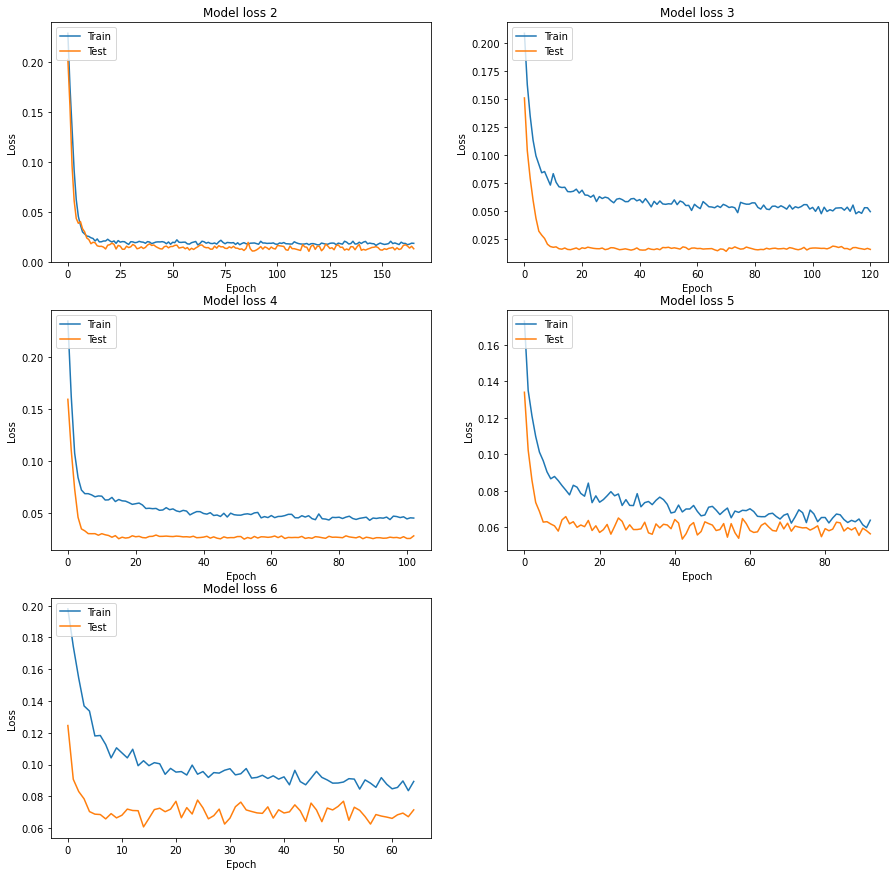

In [12]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history[i+2].history['loss'])
    plt.plot(history[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')